In [1]:
import torch
import traceback
import torch_scatter
import yaml
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import sys
import random
sys.path.append('/mnt/weka/scratch/yang.liu3/pyworkspace/3DGS')

import open3d.ml.torch as ml3d
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from os import makedirs
from torch import nn
from scene import Scene, LargeScene
from scene.datasets import GSDataset
from gaussian_renderer import render, render_v2
from utils.general_utils import safe_state
from argparse import ArgumentParser
from arguments import ModelParams, PipelineParams, get_combined_args
from gaussian_renderer import GaussianModel
from arguments import ModelParams, PipelineParams, OptimizationParams, GroupParams
from utils.loss_utils import l1_loss, ssim
from utils.camera_utils import loadCam
from utils.general_utils import build_rotation, build_symmetric
from pytorch3d.transforms import matrix_to_quaternion

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def parse_cfg(cfg):
    lp = GroupParams()
    op = GroupParams()
    pp = GroupParams()

    for arg in cfg['model_params'].items():
        setattr(lp, arg[0], arg[1])
    
    for arg in cfg['optim_params'].items():
        setattr(op, arg[0], arg[1]) 

    for arg in cfg['pipeline_params'].items():
        setattr(pp, arg[0], arg[1])
    
    return lp, op, pp

def contract_to_unisphere(
        x: torch.Tensor,
        aabb: torch.Tensor,
        ord: float = 2,
        eps: float = 1e-6,
        derivative: bool = False,
    ):
        aabb_min, aabb_max = torch.split(aabb, 3, dim=-1)
        x = (x - aabb_min) / (aabb_max - aabb_min)
        x = x * 2 - 1  # aabb is at [-1, 1]
        mag = torch.linalg.norm(x, ord=ord, dim=-1, keepdim=True)
        mask = mag.squeeze(-1) > 1

        if derivative:
            dev = (2 * mag - 1) / mag**2 + 2 * x**2 * (
                1 / mag**3 - (2 * mag - 1) / mag**4
            )
            dev[~mask] = 1.0
            dev = torch.clamp(dev, min=eps)
            return dev
        else:
            x[mask] = (2 - 1 / mag[mask]) * (x[mask] / mag[mask])
            x = x / 4 + 0.5  # [-inf, inf] is at [0, 1]
            return x

def scatter(feat, coors, mode, return_inv=True, min_points=0, unq_inv=None, new_coors=None):
    assert feat.size(0) == coors.size(0)
    if mode == 'avg':
        mode = 'mean'


    if unq_inv is None and min_points > 0:
        new_coors, unq_inv, unq_cnt = torch.unique(coors, return_inverse=True, return_counts=True, dim=0)
    elif unq_inv is None:
        new_coors, unq_inv = torch.unique(coors, return_inverse=True, return_counts=False, dim=0)
    else:
        assert new_coors is not None, 'please pass new_coors for interface consistency, caller: {}'.format(traceback.extract_stack()[-2][2])


    if min_points > 0:
        cnt_per_point = unq_cnt[unq_inv]
        valid_mask = cnt_per_point >= min_points
        feat = feat[valid_mask]
        coors = coors[valid_mask]
        new_coors, unq_inv, unq_cnt = torch.unique(coors, return_inverse=True, return_counts=True, dim=0)

    if mode == 'max':
        new_feat, argmax = torch_scatter.scatter_max(feat, unq_inv, dim=0)
    elif mode in ('mean', 'sum'):
        new_feat = torch_scatter.scatter(feat, unq_inv, dim=0, reduce=mode)
    else:
        raise NotImplementedError

    if not return_inv:
        return new_feat, new_coors
    else:
        return new_feat, new_coors, unq_inv

def scatter_gs(gaussians, gaussians_vox, coors, mode="gmm", return_inv=True, min_points=0, unq_inv=None, new_coors=None):
    assert gaussians.get_xyz.size(0) == coors.size(0)
    requires_grad = gaussians.get_xyz.requires_grad
    if mode == 'avg':
        mode = 'mean'

    if unq_inv is None and min_points > 0:
        new_coors, unq_inv, unq_cnt = torch.unique(coors, return_inverse=True, return_counts=True, dim=0)
    elif unq_inv is None:
        new_coors, unq_inv = torch.unique(coors, return_inverse=True, return_counts=False, dim=0)
    else:
        assert new_coors is not None, 'please pass new_coors for interface consistency, caller: {}'.format(traceback.extract_stack()[-2][2])
    
    if mode == "gmm":
        # get mean and cov of GMM within each voxel
        points = gaussians.get_xyz  # [M, 3]
        opacity = gaussians.get_opacity  # [M, 1]
        features = gaussians.get_features  # [M, 16, 3]
        cov3D = build_symmetric(gaussians.get_covariance())  # [M, 3, 3]

        if min_points > 0:
            cnt_per_point = unq_cnt[unq_inv]
            valid_mask = cnt_per_point >= min_points
            points = points[valid_mask]
            opacity = opacity[valid_mask]
            features = features[valid_mask]
            cov3D = cov3D[valid_mask]
            coors = coors[valid_mask]
            new_coors, unq_inv, unq_cnt = torch.unique(coors, return_inverse=True, return_counts=True, dim=0)

        norm_opacity = opacity / torch_scatter.scatter(opacity, unq_inv, dim=0, reduce='sum')[unq_inv]  # [M, 1]
        sub_means = norm_opacity * points  # [M, 3]
        gmm_means = torch_scatter.scatter(sub_means, unq_inv, dim=0, reduce='sum')  # [N, 3]

        deviation = points - gmm_means[unq_inv]  # [M, 3]
        sub_covs = norm_opacity[..., None] * (torch.bmm((deviation).unsqueeze(-1), 
                                                        (deviation).unsqueeze(-2)) + cov3D)  # [M, 3, 3]
        gmm_covs = torch_scatter.scatter(sub_covs, unq_inv, dim=0, reduce='sum')  # [N, 3, 3]
        
        # transform cov to scaling and rotation
        U, S, _ = torch.svd(gmm_covs)  # bound to be symmetric, thus U and V are the same
        q = matrix_to_quaternion(U)  # [N, 4]
        # s = torch.sqrt(S) * torch.norm(q, dim=-1, keepdim=True)
        s = torch.sqrt(S)

        # use probability as feature weights
        inv_gmm_covs = U @ torch.diag_embed(1 / S) @ U.transpose(-1, -2)  # [N, 3, 3]
        weights = opacity * torch.exp(-0.5 * torch.bmm(deviation.unsqueeze(-2), torch.bmm(inv_gmm_covs[unq_inv], deviation.unsqueeze(-1))).squeeze(-1))  # [M, 1]
        weights /= torch_scatter.scatter(weights, unq_inv, dim=0, reduce='sum')[unq_inv]  # [M, 1]

        new_feat = torch_scatter.scatter(features * weights[..., None], unq_inv, dim=0, reduce='sum')  # [N, 16, 3]
        new_opacity = torch_scatter.scatter(opacity * weights, unq_inv, dim=0, reduce='sum')  # [N, 1]

        # TODO: xyz init for GaussianModelLoD
        gaussians_vox._xyz = nn.Parameter(gmm_means.requires_grad_(requires_grad))
        gaussians_vox._rotation = nn.Parameter(q.requires_grad_(requires_grad))  # [M, 4]
        gaussians_vox._scaling = nn.Parameter(gaussians_vox.scaling_inverse_activation(s).requires_grad_(requires_grad)) # [M, 3]
        gaussians_vox._opacity = nn.Parameter(gaussians_vox.inverse_opacity_activation(new_opacity).requires_grad_(requires_grad))  # [M, 1]
        gaussians_vox._features_dc = nn.Parameter(new_feat[:, [0]].requires_grad_(requires_grad))
        gaussians_vox._features_rest = nn.Parameter(new_feat[:, 1:].requires_grad_(requires_grad))
        gaussians_vox.max_radii2D = torch.zeros((gmm_means.shape[0]), device="cuda")
    
    else:
        sh_features = gaussians.get_features.reshape(gaussians.get_xyz.shape[0], -1)
        feat = torch.cat([gaussians._xyz, gaussians._scaling, gaussians._rotation, sh_features, 
                          gaussians._opacity, gaussians.max_radii2D[:, None]], dim=-1)
        
        if min_points > 0:
            cnt_per_point = unq_cnt[unq_inv]
            valid_mask = cnt_per_point >= min_points
            feat = feat[valid_mask]
            coors = coors[valid_mask]
            new_coors, unq_inv, unq_cnt = torch.unique(coors, return_inverse=True, return_counts=True, dim=0)
        
        if mode == 'max':
            new_feat, argmax = torch_scatter.scatter_max(feat, unq_inv, dim=0)
        elif mode in ('mean', 'sum'):
            new_feat = torch_scatter.scatter(feat, unq_inv, dim=0, reduce=mode)
        else:
            raise NotImplementedError

        gaussians_vox._xyz = nn.Parameter(new_feat[:, :3].requires_grad_(requires_grad))
        gaussians_vox._scaling = nn.Parameter(new_feat[:, 3:6].requires_grad_(requires_grad))
        gaussians_vox._rotation = nn.Parameter(new_feat[:, 6:10].requires_grad_(requires_grad))
        gaussians_vox._opacity = nn.Parameter(new_feat[:, -2].requires_grad_(requires_grad))
        gaussians_vox.max_radii2D = new_feat[:, -1]

        vox_sh_features = new_feat[:, 10:-2].reshape(-1, 16, 3)
        gaussians_vox._features_dc = nn.Parameter(vox_sh_features[:, [0], :].requires_grad_(requires_grad))
        gaussians_vox._features_rest = nn.Parameter(vox_sh_features[:, 1:, :].requires_grad_(requires_grad))

    if not return_inv:
        return new_coors
    else:
        return new_coors, unq_inv

## 1. Voxelization

In [3]:
config = '../config/lod_mc_aerial_block3.yaml'
iteration = 30_000

with open(config) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    lp, op, pp = parse_cfg(cfg)
    setattr(lp, 'config_path', config)
config1_name = os.path.splitext(os.path.basename(config))[0]
lp.source_path = os.path.join("../", lp.source_path)
lp.model_path = os.path.join("../output/", config1_name)

with torch.no_grad():
    gaussians = GaussianModel(lp.sh_degree)
    scene = LargeScene(lp, gaussians, load_iteration=iteration, shuffle=False)
    # scene = LargeScene(lp, gaussians, shuffle=False)
    print(f'Loaded {lp.model_path}\n')

Loading trained model at iteration 30000
Reading camera 185/185
Loaded ../output/lod_mc_aerial_block3



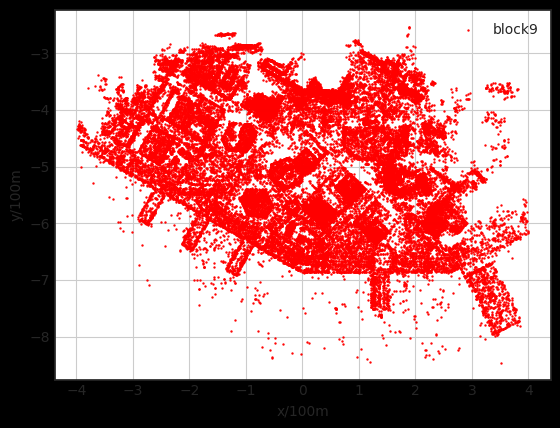

In [4]:
# show area of two blocks under BEV
xy_range = [-5, 0, 5, 4]
with torch.no_grad():
    xyz_org = gaussians.get_xyz
    aabb = torch.tensor([xy_range[0], xy_range[1], xyz_org[:, -1].min(), 
                         xy_range[2], xy_range[3], xyz_org[:, -1].max()], device='cuda')
    xyz = contract_to_unisphere(xyz_org, aabb, ord=torch.inf)

plt.figure()
plt.style.use('seaborn-white')

aabb = aabb.detach().cpu().numpy()
# plt.plot([aabb[0], aabb[0]], [aabb[1], aabb[4]], 'b')
# plt.plot([aabb[3], aabb[3]], [aabb[1], aabb[4]], 'b')
# plt.plot([aabb[0], aabb[3]], [aabb[1], aabb[1]], 'b')
# plt.plot([aabb[0], aabb[3]], [aabb[4], aabb[4]], 'b')
plt.scatter(gaussians.get_xyz[::100, 0].detach().cpu(), gaussians.get_xyz[::100, 1].detach().cpu(), s=0.5, c='r', label='block9')
# plt.xlim(xy_range[0], xy_range[2])
# plt.ylim(xy_range[1], xy_range[3])
plt.xlabel('x/100m')
plt.ylabel('y/100m')
plt.legend()
plt.grid(True)

# plt.scatter(xyz[::100, 0].detach().cpu(), xyz[::100, 1].detach().cpu(), s=0.5, c='r', label='block9')
# plt.plot([0.25, 0.25], [0.25, 0.75], 'b')
# plt.plot([0.75, 0.75], [0.25, 0.75], 'b')
# plt.plot([0.25, 0.75], [0.25, 0.25], 'b')
# plt.plot([0.25, 0.75], [0.75, 0.75], 'b')
# plt.axis('equal')
# plt.xlim(0.1, 0.9)
# plt.ylim(0.1, 0.9)
# plt.legend()
# plt.grid(True)
# plt.show()

In [97]:
points = gaussians.get_xyz
gaussians.training_setup(op)
xyz_range = torch.tensor([-4.5, -8.5, 0, 4.5, -2.5, 3], device=points.device)
voxel_size = torch.tensor([0.01, 0.01, 0.01], device=points.device)

In [98]:
# cov3D_precomp = gaussians.get_covariance()

gaussians_vox = GaussianModel(lp.sh_degree)
voxel_index = torch.div(points[:, :3] - xyz_range[None, :3], voxel_size[None, :], rounding_mode='floor')
voxel_coords = voxel_index * voxel_size[None, :] + xyz_range[None, :3] + voxel_size[None, :] / 2

new_coors, unq_inv = scatter_gs(gaussians, gaussians_vox, voxel_coords, 'gmm', return_inv=True, min_points=)
print(f"Number of voxels: {new_coors.shape[0]}")

Number of voxels: 653895


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


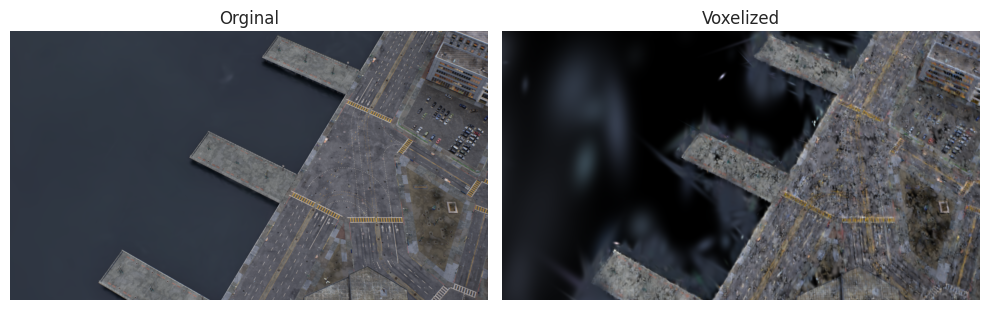

In [107]:
with torch.no_grad():
    views = scene.getTrainCameras()  # getTrainCameras, getTestCameras
    idx = random.randint(0, len(views)-1)

    bg_color = [1,1,1] if lp.white_background else [0, 0, 0]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
    viewpoint_cam = loadCam(lp, id, views[idx], 1.0)

    render_pkg = render(viewpoint_cam, gaussians, pp, background)
    image = render_pkg["render"]
    image = image.cpu().numpy().transpose(1,2,0)

    render_pkg_vox = render(viewpoint_cam, gaussians_vox, pp, background)
    image_vox = render_pkg_vox["render"]
    image_vox = image_vox.cpu().numpy().transpose(1,2,0)

    plt.figure(figsize=(10, 5))
    
    plt.subplot(121)
    plt.imshow(image)
    plt.title("Orginal")
    plt.axis(False)
    plt.subplot(122)
    plt.imshow(image_vox)
    plt.title("Voxelized")
    plt.axis(False)
    plt.tight_layout()
    plt.show()

## 2. Pick Up Training Data

In [3]:
config = '../config/block_mc_aerial_block9_cell9.yaml'
# iteration = 30_000

with open(config) as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)
    lp, op, pp = parse_cfg(cfg)
    setattr(lp, 'config_path', config)
config_name = os.path.splitext(os.path.basename(config))[0]
lp.block_id = 9
lp.source_path = os.path.join("../", lp.source_path)
lp.pretrain_path = os.path.join("../", lp.pretrain_path)
lp.model_path = os.path.join("../output/", config_name)

with torch.no_grad():
    gaussians = GaussianModel(lp.sh_degree)
    # scene = LargeScene(lp, gaussians, load_iteration=iteration, shuffle=False)
    scene = LargeScene(lp, gaussians, shuffle=False)
    gs_dataset = GSDataset(scene.getTrainCameras(), scene, lp, pp)
    print(f'Loaded {lp.model_path}\n')

Reading camera 1689/1689
Getting Data of Block 9 / 16


  0%|          | 0/1689 [00:00<?, ?it/s]

[ INFO ] Encountered quite large input images (>1.6K pixels width), rescaling to 1.6K.
 If this is not desired, please explicitly specify '--resolution/-r' as 1


100%|██████████| 1689/1689 [05:30<00:00,  5.11it/s]

Filtered Cameras: 458
Loaded ../output/block_mc_aerial_block9_cell9



In [158]:
with torch.no_grad():
    gs_mask = (gaussians.get_opacity > 0.005).squeeze()
    sh_degree = lp.sh_degree
    masked_gaussians = GaussianModel(sh_degree)
    masked_gaussians._xyz = gaussians._xyz[gs_mask]
    masked_gaussians._scaling = gaussians._scaling[gs_mask]
    masked_gaussians._rotation = gaussians._rotation[gs_mask]
    masked_gaussians._features_dc = gaussians._features_dc[gs_mask]
    masked_gaussians._features_rest = gaussians._features_rest[gs_mask]
    masked_gaussians._opacity = gaussians._opacity[gs_mask]
    masked_gaussians.max_radii2D = gaussians.max_radii2D[gs_mask]

In [177]:
avg_loss = 0
with torch.no_grad():
    for idx in tqdm(range(len(gs_dataset))):
        bg_color = [1,1,1] if lp.white_background else [0, 0, 0]
        background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

        cam_info, gt_image = gs_dataset[idx]
        render_pkg = render_v2(cam_info, masked_gaussians, pp, background)
        image = render_pkg["render"]

        gt_image = gt_image.cuda()
        Ll1 = l1_loss(image, gt_image)
        loss = (1.0 - op.lambda_dssim) * Ll1 + op.lambda_dssim * (1.0 - ssim(image, gt_image))
        avg_loss += loss.item()
print("Average loss: {:.4f}".format(avg_loss / len(gs_dataset)))

100%|██████████| 458/458 [00:44<00:00, 10.26it/s]

Average loss: 0.0688


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


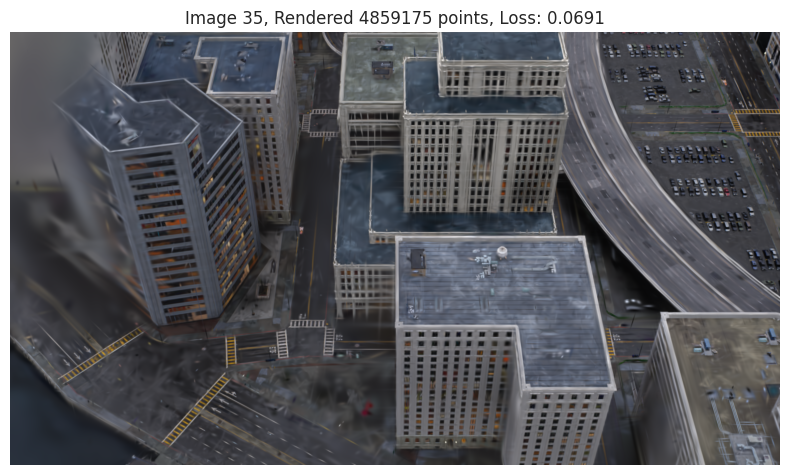

In [176]:
# for cell 9 in block 9, the avg loss is 0.0593
with torch.no_grad():
    # idx = random.randint(0, len(gs_dataset)-1)
    idx = 35

    bg_color = [1,1,1] if lp.white_background else [0, 0, 0]
    background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

    cam_info, gt_image = gs_dataset[idx]
    render_pkg = render_v2(cam_info, gaussians, pp, background)
    # render_pkg = render_v2(cam_info, masked_gaussians, pp, background)
    image = render_pkg["render"]

    gt_image = gt_image.cuda()
    Ll1 = l1_loss(image, gt_image)
    loss = (1.0 - op.lambda_dssim) * Ll1 + op.lambda_dssim * (1.0 - ssim(image, gt_image))
    image = image.cpu().numpy().transpose(1,2,0)

    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title(f"Image {idx}, Rendered {render_pkg['radii'].shape[0]} points, Loss: {loss.item():.4f}")
    plt.axis(False)
    plt.tight_layout()
    plt.show()

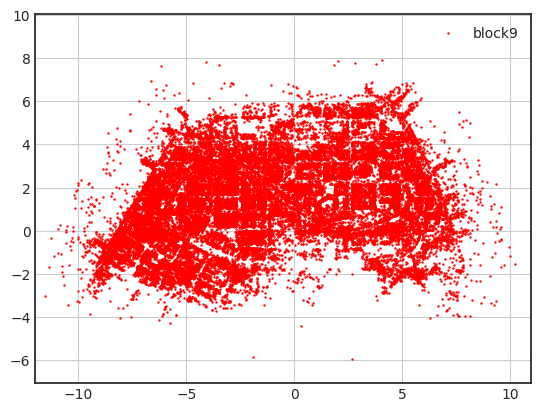

In [15]:
# show area of two blocks under BEV
xy_range = [-5, 0, 5, 4]
with torch.no_grad():
    xyz_org = gaussians.get_xyz
    aabb = torch.tensor([xy_range[0], xy_range[1], xyz_org[:, -1].min(), 
                         xy_range[2], xy_range[3], xyz_org[:, -1].max()], device='cuda')
    xyz = contract_to_unisphere(xyz_org, aabb, ord=torch.inf)

plt.figure()
plt.style.use('seaborn-white')

plt.scatter(gaussians.get_xyz[::100, 0].detach().cpu(), gaussians.get_xyz[::100, 1].detach().cpu(), s=0.5, c='r', label='block9')
# plt.plot([0.25, 0.25], [0.25, 0.75], 'b')
# plt.plot([0.75, 0.75], [0.25, 0.75], 'b')
# plt.plot([0.25, 0.75], [0.25, 0.25], 'b')
# plt.plot([0.25, 0.75], [0.75, 0.75], 'b')
plt.axis('equal')
plt.xlim(-12, 11)
plt.ylim(-4, 7)
plt.legend()
plt.grid(True)
plt.show()

In [12]:
from utils.general_utils import build_rotation

# range_gs = [-2.5, 0, 2, 4]  # min_x, max_x, min_y, max_y
# R = build_rotation(gaussians.get_rotation)
# centers = gaussians.get_xyz
# scales = gaussians.get_scaling
# l, w, h = scales[:, 0], scales[:, 1], scales[:, 2]
# corners = torch.stack([torch.stack([-l/2, -w/2, -h/2], dim=-1),
#                        torch.stack([l/2, -w/2, -h/2], dim=-1),
#                        torch.stack([-l/2, w/2, -h/2], dim=-1),
#                        torch.stack([l/2, w/2, -h/2], dim=-1),
#                        torch.stack([-l/2, -w/2, h/2], dim=-1),
#                        torch.stack([l/2, -w/2, h/2], dim=-1),
#                        torch.stack([-l/2, w/2, h/2], dim=-1),
#                        torch.stack([l/2, w/2, h/2], dim=-1)], dim=1)
# corners = torch.matmul(corners, R.transpose(1, 2)) + centers.unsqueeze(1)
# gs_mask = (corners[:, :, 0] > range_gs[0]) & (corners[:, :, 0] < range_gs[1]) & \
#            (corners[:, :, 1] > range_gs[2]) & (corners[:, :, 1] < range_gs[3])
# gs_mask = gs_mask.sum(dim=1) == 8

block_id = 9
block_dim = [4, 4, 1]
block_id_z = block_id // (block_dim[0] * block_dim[1])
block_id_y = (block_id % (block_dim[0] * block_dim[1])) // block_dim[1]
block_id_x = (block_id % (block_dim[0] * block_dim[1])) % block_dim[1]

min_x, max_x = float(block_id_x) / block_dim[0], float(block_id_x + 1) / block_dim[0]
min_y, max_y = float(block_id_y) / block_dim[1], float(block_id_y + 1) / block_dim[1]
min_z, max_z = float(block_id_z) / block_dim[2], float(block_id_z + 1) / block_dim[2]

block_num = block_dim[0] * block_dim[1] * block_dim[2]
gs_mask = (xyz[:, 0] >= min_x) & (xyz[:, 0] < max_x)  \
            & (xyz[:, 1] >= min_y) & (xyz[:, 1] < max_y) \
            & (xyz[:, 2] >= min_z) & (xyz[:, 2] < max_z)

sh_degree = lp.sh_degree
masked_gaussians = GaussianModel(sh_degree)
masked_gaussians._xyz = gaussians._xyz[gs_mask]
masked_gaussians._scaling = gaussians._scaling[gs_mask]
masked_gaussians._rotation = gaussians._rotation[gs_mask]
masked_gaussians._features_dc = gaussians._features_dc[gs_mask]
masked_gaussians._features_rest = gaussians._features_rest[gs_mask]
masked_gaussians._opacity = gaussians._opacity[gs_mask]
masked_gaussians.max_radii2D = gaussians.max_radii2D[gs_mask]

print(f"Range of masked gaussians: [\n{masked_gaussians.get_xyz.min(dim=0).values}, \n{masked_gaussians.get_xyz.max(dim=0).values}]")

Range of masked gaussians: [
tensor([-5.0000,  2.0000, -7.1772], device='cuda:0', grad_fn=<MinBackward0>), 
tensor([-7.2663e-05,  4.0000e+00,  4.7076e+00], device='cuda:0',
       grad_fn=<MaxBackward0>)]


  0%|          | 0/1689 [00:00<?, ?it/s]

[ INFO ] Encountered quite large input images (>1.6K pixels width), rescaling to 1.6K.
 If this is not desired, please explicitly specify '--resolution/-r' as 1


  2%|▏         | 33/1689 [00:06<04:37,  5.96it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


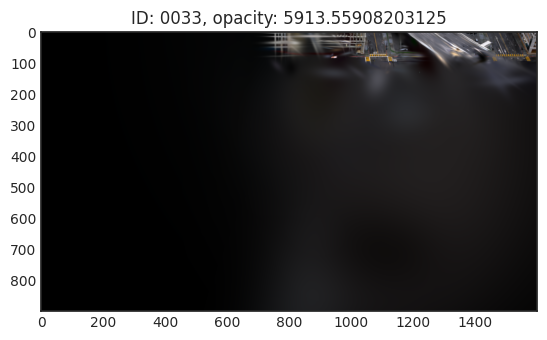

  2%|▏         | 34/1689 [00:06<08:20,  3.31it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


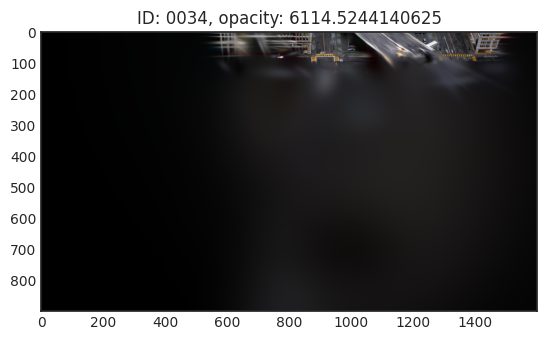

  2%|▏         | 35/1689 [00:07<10:50,  2.54it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


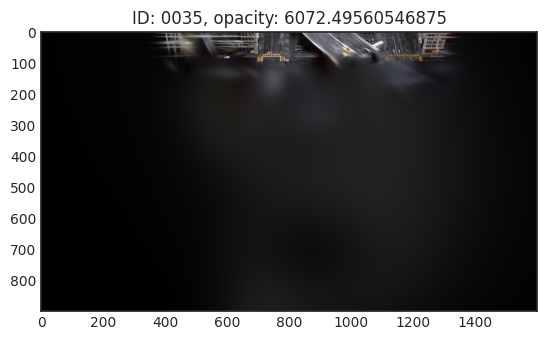

  2%|▏         | 36/1689 [00:08<12:34,  2.19it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


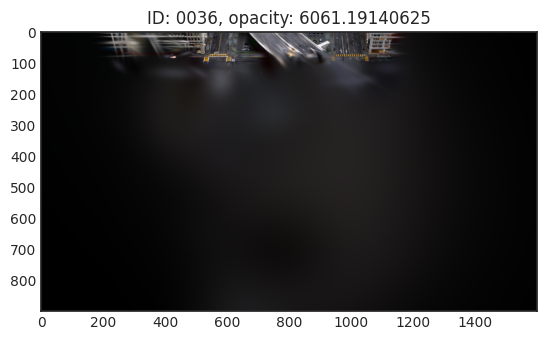

  2%|▏         | 37/1689 [00:08<13:51,  1.99it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


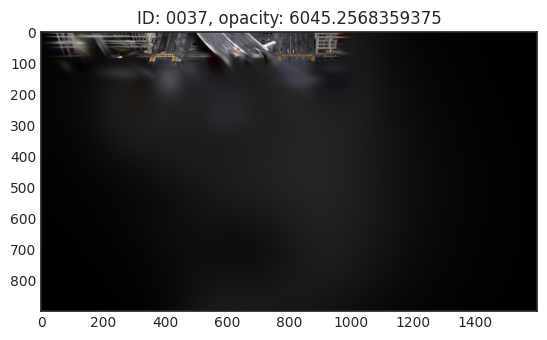

  2%|▏         | 38/1689 [00:09<14:49,  1.86it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


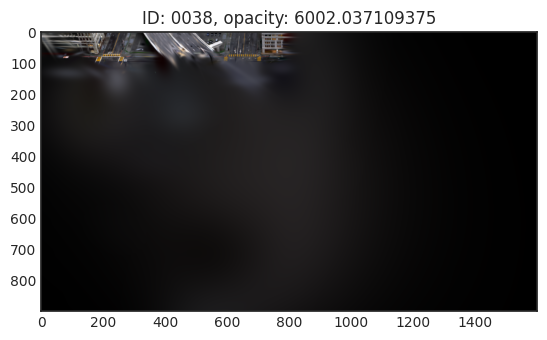

  2%|▏         | 39/1689 [00:09<15:28,  1.78it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


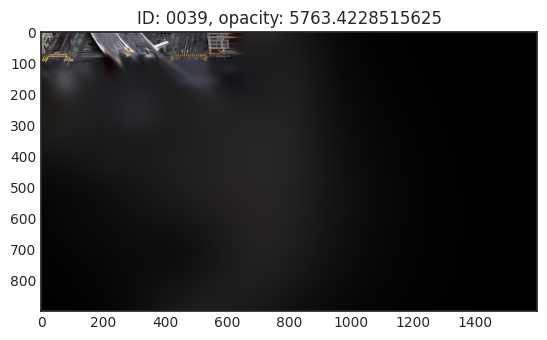

  2%|▏         | 40/1689 [00:10<16:56,  1.62it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


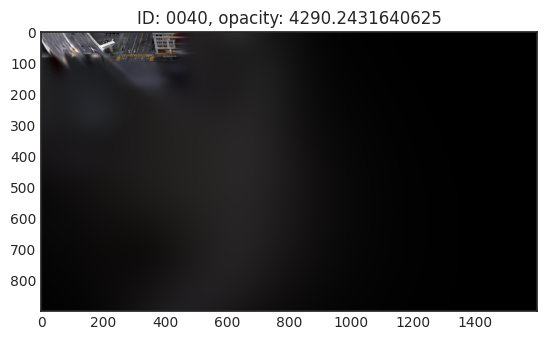

  3%|▎         | 44/1689 [00:11<09:05,  3.02it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


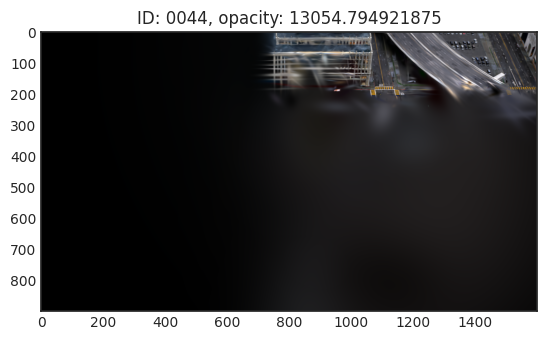

  3%|▎         | 45/1689 [00:12<11:17,  2.43it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


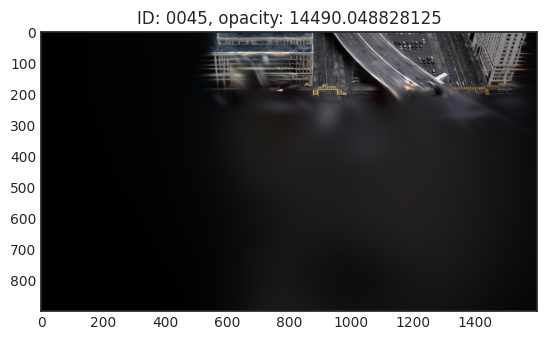

  3%|▎         | 46/1689 [00:13<12:57,  2.11it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


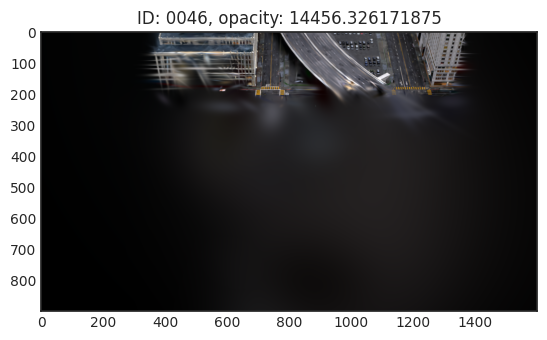

  3%|▎         | 46/1689 [00:13<08:08,  3.36it/s]


In [16]:
opacity_list = []
valid_num = 0
with torch.no_grad():
    views = scene.getTrainCameras()  # getTrainCameras, getTestCameras
    for idx in tqdm(range(len(views))):
        bg_color = [1,1,1] if lp.white_background else [0, 0, 0]
        background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
        viewpoint_cam = loadCam(lp, id, views[idx], 1.0)

        render_pkg_block = render(viewpoint_cam, masked_gaussians, pp, background)
        image_block = render_pkg_block["render"]
        visibility_filter = render_pkg_block["visibility_filter"]
        total_opacity = render_pkg_block["geometry"][visibility_filter, 6].sum()
        opacity_list.append(total_opacity)
        image_block = image_block.cpu().numpy().transpose(1,2,0)

        if total_opacity > 4000:
            valid_num += 1
            ID = views[idx].image_path.split('/')[-1].split('.')[0]
            plt.figure()
            plt.imshow(image_block)
            plt.title(f'ID: {ID}, opacity: {total_opacity}')
            plt.show()
            if valid_num > 10:
                break
# print(f'Valid_num: {valid_num}')